<a href="https://colab.research.google.com/github/GoldPapaya/synonym-pathfinder/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print(wn.synset('bank.n.07').definition())
print(wn.synset('bank.n.07').lemma_names())
print(wn.synsets('cant'))

a slope in the turn of a road or track; the outside is higher than the inside in order to reduce the effects of centrifugal force
['bank', 'cant', 'camber']
[Synset('buzzword.n.01'), Synset('bank.n.07'), Synset('slang.n.02'), Synset('cant.n.04'), Synset('bevel.n.01'), Synset('cant.v.01')]


In [ ]:
print(wn.synset('depository_financial_institution.n.01').lemmas())

print(wn.synsets('banking_concern'))
print(wn.synsets('banking_company'))
print(wn.synsets('bank'))


[Lemma('depository_financial_institution.n.01.depository_financial_institution'), Lemma('depository_financial_institution.n.01.bank'), Lemma('depository_financial_institution.n.01.banking_concern'), Lemma('depository_financial_institution.n.01.banking_company')]
[Synset('depository_financial_institution.n.01')]
[Synset('depository_financial_institution.n.01')]
[Synset('bank.n.01'), Synset('depository_financial_institution.n.01'), Synset('bank.n.03'), Synset('bank.n.04'), Synset('bank.n.05'), Synset('bank.n.06'), Synset('bank.n.07'), Synset('savings_bank.n.02'), Synset('bank.n.09'), Synset('bank.n.10'), Synset('bank.v.01'), Synset('bank.v.02'), Synset('bank.v.03'), Synset('bank.v.04'), Synset('bank.v.05'), Synset('deposit.v.02'), Synset('bank.v.07'), Synset('trust.v.01')]


In [1]:
import numpy as np
from scipy.spatial.distance import cosine
# https://www.geeksforgeeks.org/nlp/nlp-wupalmer-wordnet-similarity/

def synset_cosine_similarity(synset_1, synset_2):
    wup = synset_1.wup_similarity(synset_2)
    if not wup: # edge case: if no lcs, return a weight of 0
      return 0.0
    return float(wup)

In [20]:
!pip install nltk networkx matplotlib ipympl
import nltk
nltk.download('wordnet', quiet=True)
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
import networkx as nx
%matplotlib ipympl

class WordNetGraph:
    def __init__(self):
        self.graph = nx.Graph()

    def add_synset_node(self, synset):
        self.graph.add_node(synset.name())

    def get_neighbors(self, synset_name):
        return list(self.graph.neighbors(synset_name))

    def add_synset_edges(self, synset):
        synset_name = synset.name()
        self.add_synset_node(synset)
        neighbor_synsets = set()
        for lemma in synset.lemmas():
            lemma_name = lemma.name()
            for neighbor in wn.synsets(lemma_name, pos=synset.pos()):
                if neighbor != synset:
                    neighbor_synsets.add(neighbor)
                    weight = synset_cosine_similarity(synset, neighbor)
                    self.graph.add_edge(synset.name(), neighbor.name(), weight=weight)
        return neighbor_synsets

    def build_graph_from_synset(self, input_synset_str, depth): # driver
        start_synset = wn.synset(input_synset_str)
        self.graph.clear()
        self.add_synset_node(start_synset)

        to_process = {start_synset}
        processed = set()

        for _ in range(depth + 1):
            next_to_process = set()
            for synset in to_process:
                if synset not in processed:
                    neighbors = self.add_synset_edges(synset)
                    if _ < depth:
                        next_to_process.update(neighbors - processed)
                    processed.add(synset)
            to_process = next_to_process

    def get_all_definitions(self) -> dict:
        definitions = {}
        for node_name in self.graph.nodes():
            try:
                synset = wn.synset(node_name)
                definitions[node_name] = synset.definition()
            except Exception as e:
                definitions[node_name] = f"[ERROR: {e}]"
        return definitions

    def draw(self, **kwargs):
        plt.figure(figsize=(12, 9))
        pos = nx.spring_layout(self.graph, k=2, iterations=60, seed=42)

        # nodes
        nx.draw_networkx_nodes(
            self.graph, pos,
            node_color='lightblue',
            node_size=2200,
            alpha=0.9
        )

        # edges
        edges = self.graph.edges(data=True)
        weights = [e[2]['weight'] for e in edges]
        if weights:
            # scale thickness
            thickness = 0.5 + 5.5 * np.array(weights)
        else:
            thickness = [1.0] * len(edges)

        nx.draw_networkx_edges(
            self.graph, pos,
            width=thickness,
            alpha=0.6,
            edge_color='gray'
        )

        # labels
        nx.draw_networkx_labels(
            self.graph, pos,
            font_size=9,
            font_weight='bold'
        )

        plt.title('WordNet Synset Graph')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [37]:
# tests
wn_graph = WordNetGraph()
test_synset = 'plant.n.01'
wn_graph.build_graph_from_synset(test_synset, depth=1)

# print all graph neighbors of a synset
print(f"Neighbors: {wn_graph.get_neighbors(test_synset)}\n")

Neighbors: ['plant.n.02', 'plant.n.03', 'plant.n.04', 'whole_shebang.n.01', 'works.n.03', 'works.n.04', 'work.n.01', 'work.n.02', 'employment.n.02', 'study.n.02', 'work.n.05', 'workplace.n.01', 'oeuvre.n.01']



In [38]:
print("Nodes:", list(wn_graph.graph.nodes()))

Nodes: ['plant.n.01', 'plant.n.02', 'plant.n.03', 'plant.n.04', 'whole_shebang.n.01', 'works.n.03', 'works.n.04', 'work.n.01', 'work.n.02', 'employment.n.02', 'study.n.02', 'work.n.05', 'workplace.n.01', 'oeuvre.n.01', 'deed.n.01', 'act.n.02', 'survey.n.01', 'report.n.01', 'study.n.04', 'study.n.05', 'discipline.n.01', 'sketch.n.01', 'cogitation.n.02', 'study.n.09', 'study.n.10', 'working.n.01', 'vegetation.n.01', 'employment.n.01', 'employment.n.03', 'use.n.01']


In [39]:
print("\nEdges:")
for u, v, data in wn_graph.graph.edges(data=True):
    weight = data.get('weight', 0.0)
    print(f"{u} -- {v}  (weight = {weight:.4f})")


Edges:
plant.n.01 -- plant.n.02  (weight = 0.5333)
plant.n.01 -- plant.n.03  (weight = 0.4211)
plant.n.01 -- plant.n.04  (weight = 0.1053)
plant.n.01 -- whole_shebang.n.01  (weight = 0.1250)
plant.n.01 -- works.n.03  (weight = 0.1333)
plant.n.01 -- works.n.04  (weight = 0.5882)
plant.n.01 -- work.n.01  (weight = 0.1333)
plant.n.01 -- work.n.02  (weight = 0.6250)
plant.n.01 -- employment.n.02  (weight = 0.1250)
plant.n.01 -- study.n.02  (weight = 0.1250)
plant.n.01 -- work.n.05  (weight = 0.2500)
plant.n.01 -- workplace.n.01  (weight = 0.4000)
plant.n.01 -- oeuvre.n.01  (weight = 0.5882)
plant.n.02 -- plant.n.03  (weight = 0.6667)
plant.n.02 -- plant.n.04  (weight = 0.1111)
plant.n.02 -- vegetation.n.01  (weight = 0.1667)
plant.n.03 -- plant.n.04  (weight = 0.1053)
whole_shebang.n.01 -- works.n.03  (weight = 0.2667)
whole_shebang.n.01 -- works.n.04  (weight = 0.1176)
whole_shebang.n.01 -- work.n.01  (weight = 0.2667)
whole_shebang.n.01 -- work.n.02  (weight = 0.1250)
whole_shebang.n.01

In [40]:
definitions = wn_graph.get_all_definitions()
for synset_name, definition in definitions.items():
    print(f"{synset_name}: {definition}")

plant.n.01: buildings for carrying on industrial labor
plant.n.02: (botany) a living organism lacking the power of locomotion
plant.n.03: an actor situated in the audience whose acting is rehearsed but seems spontaneous to the audience
plant.n.04: something planted secretly for discovery by another
whole_shebang.n.01: everything available; usually preceded by `the'
works.n.03: performance of moral or religious acts
works.n.04: the internal mechanism of a device
work.n.01: activity directed toward making or doing something
work.n.02: a product produced or accomplished through the effort or activity or agency of a person or thing
employment.n.02: the occupation for which you are paid
study.n.02: applying the mind to learning and understanding a subject (especially by reading)
work.n.05: (physics) a manifestation of energy; the transfer of energy from one physical system to another expressed as the product of a force and the distance through which it moves a body in the direction of that 

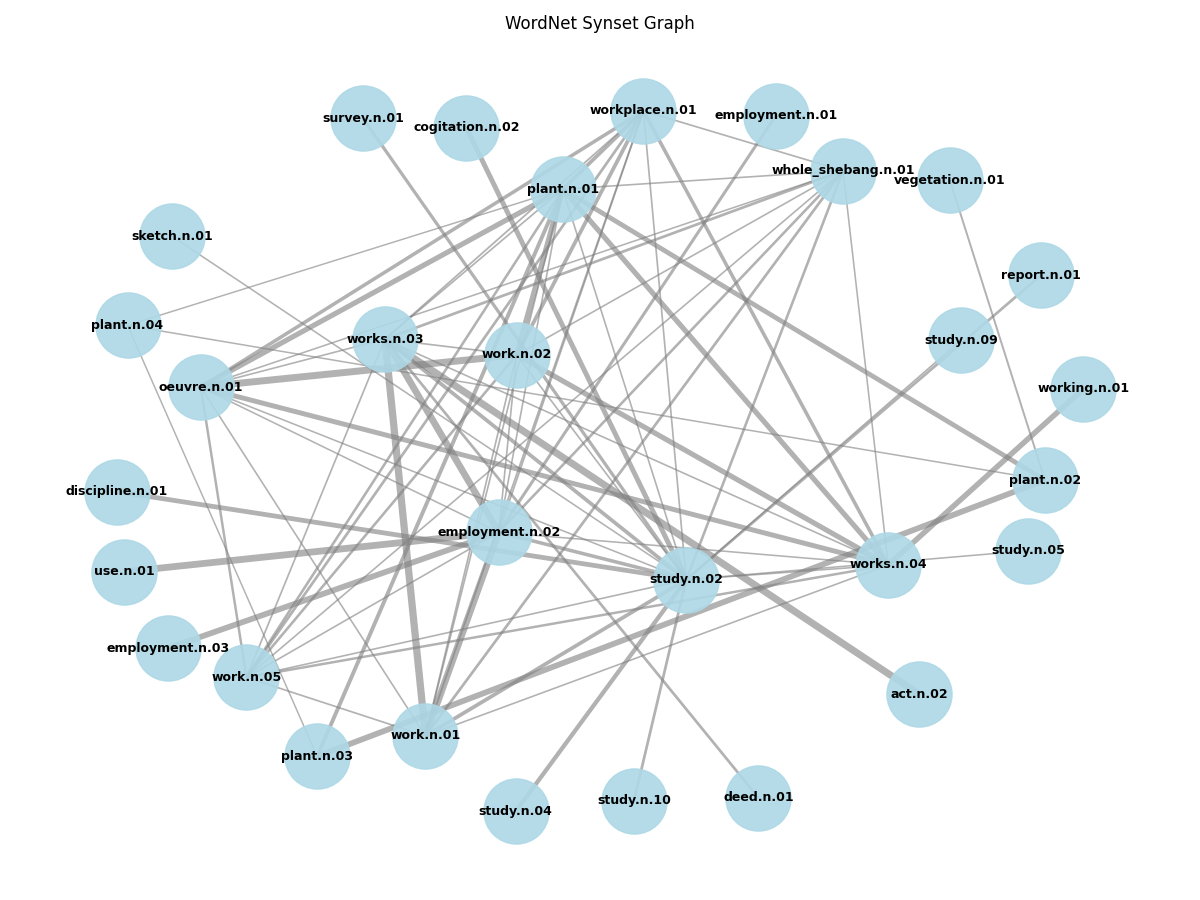

In [41]:
from google.colab import output
output.enable_custom_widget_manager()
wn_graph.draw()